# Analysis of the ISM Manufacturing Index

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

In [31]:
# Data
data = pd.read_excel("Bloomberg Data.xlsx", sheet_name="Clean")
data = data[['S&P Price Index', "S&P TR Index", 'US 3M', 'US 2Y', 'US 10Y', 'ISM Manufacturing']]
data.columns = ['SP_price', "SP_tr",'3m','2y','10y','ISM']

In [33]:
# Transformations
data['SP_mom'] = np.log(data['SP_price'] / data['SP_price'].shift(1))
data['SP_yoy'] = np.log(data['SP_price'] / data['SP_price'].shift(12))

data['SPtr_mom'] = np.log(data['SP_tr'] / data['SP_tr'].shift(1))
data['SPtr_yoy'] = np.log(data['SP_tr'] / data['SP_tr'].shift(12))

data['10-2'] = data['10y'] - data['2y']
data['10-3m'] = data['10y'] - data['3m']

In [35]:
data

,SP_price,SP_tr,3m,2y,10y,ISM,SP_mom,SP_yoy,SPtr_mom,SPtr_yoy,10-2,10-3m
0,25.74,25.7400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,25.59,25.5900,NaN,NaN,NaN,NaN,-0.005845,NaN,-0.005845,NaN,NaN,NaN
2,25.53,25.5300,NaN,NaN,NaN,NaN,-0.002347,NaN,-0.002347,NaN,NaN,NaN
3,25.94,25.9400,NaN,NaN,NaN,NaN,0.015932,NaN,0.015932,NaN,NaN,NaN
4,24.83,24.8300,NaN,NaN,NaN,NaN,-0.043734,NaN,-0.043734,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1120,4132.15,96292.9167,1.0392,2.5565,2.8441,56.1,0.000053,-0.017265,0.001834,-0.003160,0.2876,1.8049
1121,3785.38,88338.9990,1.6262,2.9533,3.0129,53.0,-0.087652,-0.126887,-0.086213,-0.112447,0.0596,1.3867
1122,4130.29,96484.4703,2.3168,2.8844,2.6487,52.8,0.087201,-0.062179,0.088200,-0.047722,-0.2357,0.3319
1123,3955.00,92549.5810,2.9003,3.4929,3.1926,52.8,-0.043367,-0.134124,-0.041638,-0.119313,-0.3003,0.2923


#### Preliminary Plots

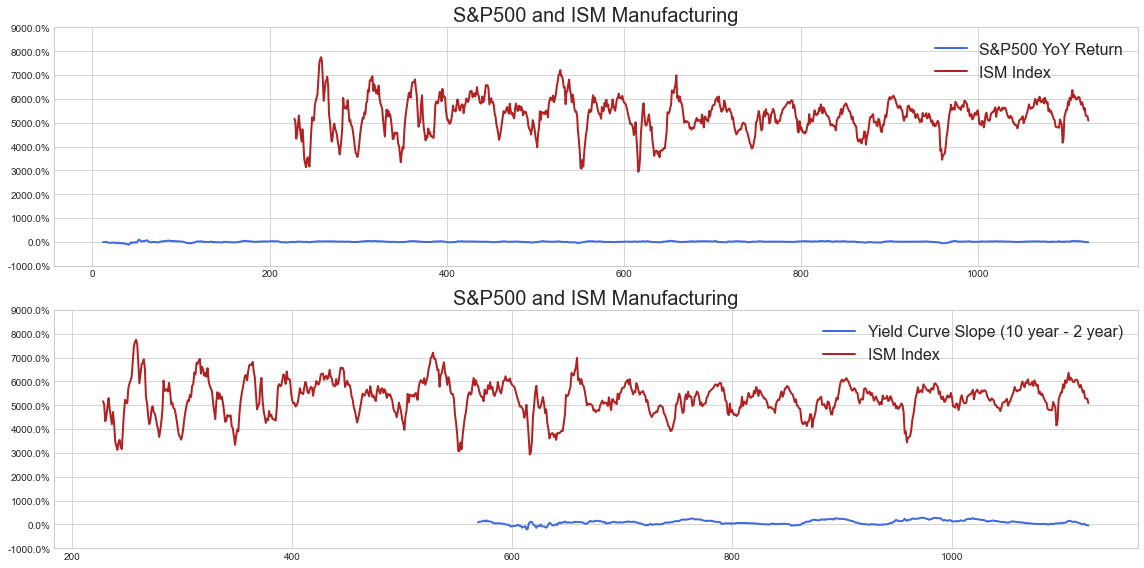

In [34]:
fig, ax = plt.subplots(2, 1, figsize=(16,8))

ax1 = data["SP_yoy"].plot(ax=ax[0], legend=True, label="S&P500 YoY Return", color='royalblue', linewidth=2)
ax1 = data["ISM"].plot(ax=ax[0], legend=True, label="ISM Index", color='firebrick', linewidth=2)
ax1.set_title('S&P500 and ISM Manufacturing', fontsize=20)
ax1.legend(fontsize=16)
ax1.set_xlabel("")
ax1.set_yticks(ax1.get_yticks())
y_labels = ax1.get_yticks()
ax1.set_yticklabels([f'{x:0.1%}' for x in y_labels])


ax2 = data["10-2"].plot(ax=ax[1], legend=True, label="Yield Curve Slope (10 year - 2 year)", color='royalblue', linewidth=2)
ax2 = data["ISM"].plot(ax=ax[1], legend=True, label="ISM Index", color='firebrick', linewidth=2)
ax2.set_title('S&P500 and ISM Manufacturing', fontsize=20)
ax2.legend(fontsize=16)
ax2.set_xlabel("")
ax2.set_yticks(ax2.get_yticks())
y_labels = ax2.get_yticks()
ax2.set_yticklabels([f'{x:0.1%}' for x in y_labels])

fig.tight_layout()
plt.show()